# data

Load OHLC data from cryptocurrency exchange Poloniex

In [60]:
from vectorbt import data, graphics
from datetime import datetime
import pytz
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)

In [2]:
ohlc_df = data.load_cryptopair('USDT_BTC', data.ago_dt(days=30), data.now_dt())
ohlc_df.head()

Finished. 1.18s


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-10-18 00:10:00,5520.000000,5520.801091,5511.100000,5518.600000,28.358664,156401.832947,5515.133935
2017-10-18 00:15:00,5527.482299,5538.889350,5519.405098,5520.000000,8.675329,47982.834531,5530.952599
2017-10-18 00:20:00,5527.000000,5544.627529,5517.482299,5527.482299,20.602430,113996.462272,5533.156092
2017-10-18 00:25:00,5510.804960,5520.057900,5509.540639,5515.133916,49.013608,270134.525097,5511.418881
2017-10-18 00:30:00,5534.000000,5536.837915,5520.057900,5520.057900,8.841663,48899.777032,5530.608699


In [3]:
rate_sr = ohlc_df['open']

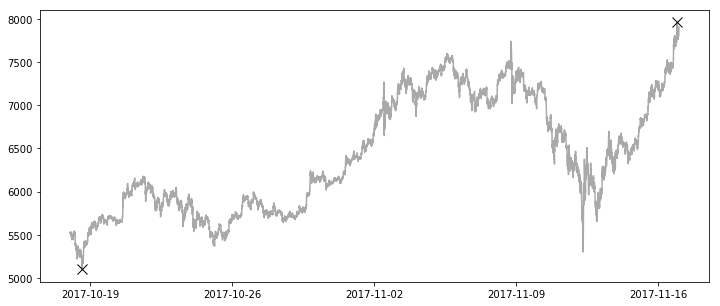

In [61]:
graphics.plot_line(rate_sr)

# strategy

Generate signals for simple moving average strategy

In [5]:
from vectorbt import strategy
import numpy as np

Build 20 and 30 moving averages

In [6]:
fast_ema_sr = strategy.ema(rate_sr, 20)
slow_ema_sr = strategy.ema(rate_sr, 50)
print(fast_ema_sr.head())
print(slow_ema_sr.head())

date
2017-10-18 00:10:00    5518.600000
2017-10-18 00:15:00    5518.733333
2017-10-18 00:20:00    5519.566568
2017-10-18 00:25:00    5519.144411
2017-10-18 00:30:00    5519.231410
Name: open, dtype: float64
date
2017-10-18 00:10:00    5518.600000
2017-10-18 00:15:00    5518.654902
2017-10-18 00:20:00    5519.001074
2017-10-18 00:25:00    5518.849421
2017-10-18 00:30:00    5518.896812
Name: open, dtype: float64


Go long whenever fast SMA is over slow SMA by threshold (in % of current rate), while go short when opposite occurs

In [7]:
ema_entry_vector = strategy.ma_entry_vector(rate_sr, fast_ema_sr, slow_ema_sr, th=(0.01, 0.01))
ema_exit_vector = strategy.ma_exit_vector(rate_sr, fast_ema_sr, slow_ema_sr, th=(0.01, 0.01))
print(np.flatnonzero(ema_entry_vector))
print(np.flatnonzero(ema_exit_vector))

[ 754 2454 3409 4335 4452 6086 7299 7317 7552 7608 7618 7793 8093 8216 8571
 8616]
[  94  171 1211 1747 1990 5685 5699 6276 6278 6286 6762 6844 7056 7239 7257
 7453 7708]


Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to speed up vector operations and to allow application of additional filters on them. Each vector is reduced (and sparse) and contains only signals that are first in their sequences. This way, we get neither outdated signals, nor typical issues like entry immediatelly after exit or vice versa. To apply a filter, create your own (not sparse) bit-vector and multiply with signals.

# positions

In [8]:
from vectorbt import positions

Generete positions out of both vectors (merge and reduce)

In [9]:
position_sr = positions.from_vectors(rate_sr, ema_entry_vector, ema_exit_vector)
position_sr.head()

date
2017-10-20 15:00:00    1
2017-10-22 05:05:00   -1
2017-10-26 12:40:00    1
2017-11-06 17:55:00   -1
2017-11-08 03:20:00    1
dtype: int64

Position series has always even number of positions. First position is always long, the last one always short. This kind of fixed structure (`[0::2]` for long, `[1::2]` for short) makes further manipulations, such as calculation of equity, very easy.

Visualize entries and exits

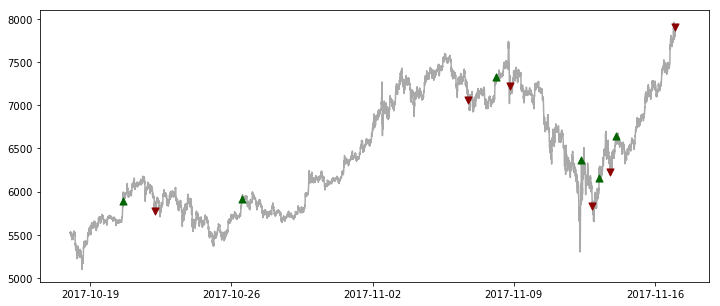

In [62]:
positions.plot(rate_sr, position_sr)

# returns

In [11]:
from vectorbt import returns

Generate % returns out of positions. Takes into account fees.

In [12]:
posret_sr = returns.from_positions(rate_sr, position_sr, 0.0015)
posret_sr.head()

date
2017-10-20 15:00:00   -0.001500
2017-10-22 05:05:00   -0.020383
2017-10-26 12:40:00   -0.001500
2017-11-06 17:55:00    0.191785
2017-11-08 03:20:00   -0.001500
dtype: float64

Position returns series (`posret`) inherits the structure of the position series and make them redundant. Because we apply fees, we get negative returns on long. If fees are zero, returns on long are also zero, but still included in the series. 

Generate hold returns.

In [13]:
returns.on_hold(rate_sr, 0.0015)

2017-10-18 00:10:00   -0.001500
2017-11-17 00:05:00    0.432429
dtype: float64

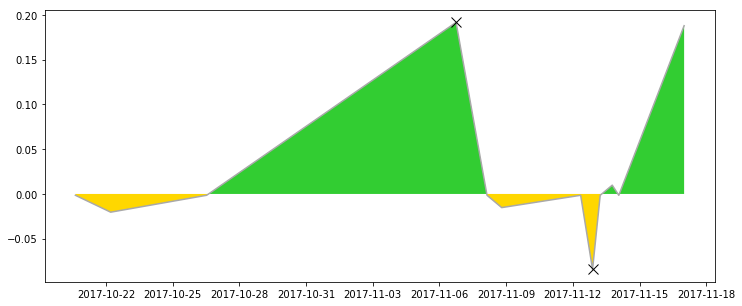

In [124]:
returns.plot(posret_sr)

# equity

In [15]:
from vectorbt import equity

Generate equity in base and quote currency from position returns

In [16]:
equity_df = equity.from_returns(rate_sr, posret_sr)
equity_df.head()

,base,quote
date,,
2017-10-18 00:10:00,NaN,NaN
2017-10-18 00:15:00,NaN,NaN
2017-10-18 00:20:00,NaN,NaN
2017-10-18 00:25:00,NaN,NaN
2017-10-18 00:30:00,NaN,NaN


Base and quote are NaN before the first entry or if no positions were taken

Visualize both equities

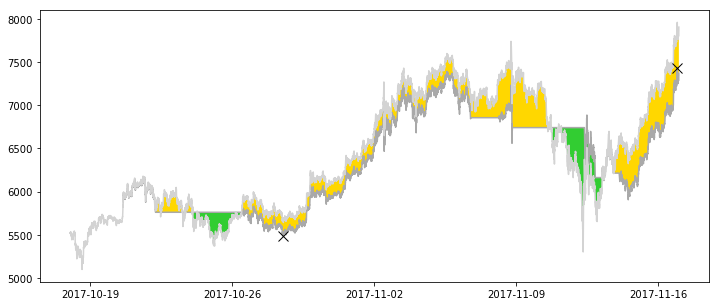

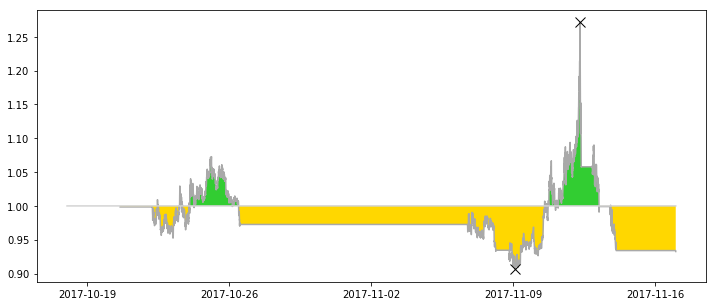

In [125]:
equity.plot(rate_sr, equity_df)

Equity diffs (`eqd`) are absolute returns if initial investment was 1. They are used in calculation of performance and risk/profit indicators such as sharpe ratio.

In [19]:
eqd_sr = equity.diff_on_positions(posret_sr)
eqd_sr.head()

date
2017-10-20 15:00:00   -0.001500
2017-10-22 05:05:00   -0.020353
2017-10-26 12:40:00   -0.001467
2017-11-06 17:55:00    0.187313
2017-11-08 03:20:00   -0.001746
dtype: float64

# indicators

Every indicator uses equity diffs as input

In [20]:
from vectorbt import indicators
import json

In [21]:
indicators.print_summary(eqd_sr)

{
  "backtest": {
    "from": "2017-10-20 15:00:00",
    "to": "2017-11-17 00:05:00",
    "days": 27,
    "trades": 12
  },
  "performance": {
    "profit": 0.25155398788827865,
    "averages": {
      "trade": 0.04352268009466435,
      "gain": 0.13188707626907606,
      "loss": 0.04484171607974737
    },
    "winrate": 0.5,
    "payoff": 2.941169245943343,
    "PF": 2.9411692459433434,
    "RF": 2.287208129652901
  },
  "risk/return profile": {
    "sharpe": 4.499321764015828,
    "sortino": 11.818322639021016,
    "maxdd": 0.1141724170977021
  }
}


# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 5 levels:**

| Level | Operation | Result | Use cases |
|-|-|-|-|
| L1 | Calculate positions | `posmap` (dict) | Transformed into returns, equity or equity diffs |
| L2 | Calculate equity diffs | `eqdmap` (dict) | Used in calculation of indicators |
| L3 | Apply KPIs | `kpimap_sr` (series) | Used in comparing strategies, building a score or a matrix |
| L4 | Bind KPIs into a score | `scoremap_sr` (series) | Takes into account and examines multiple KPIs |
| L5 | Convert into a matrix | `matrix_df` (dataframe) | Constructs a heatmap |

At the end we will be able to compare performance of different trading strategies.

## L1
## posmap

Position series keyed by parameter combinations

In [22]:
from vectorbt.optimizer.gridsearch import posmap

<module 'vectorbt.optimizer.gridsearch.posmap' from '/Users/olegpolakow/Documents/SourceTree/vector-bt/vectorbt/optimizer/gridsearch/posmap.py'>

Generate combinations of fast and slow SMA (from 1 to 100) and their resulting positions

In [23]:
sma_posmap = posmap.ma(rate_sr, 1, 100, 1, (0.01, 0.01), strategy.sma)

ma-posmap
setup: ma_func = sma, th = (0.01, 0.01)
grid: 1.000000 -> 100.000000 = 5050
calcs: 5050 (~12.19s)
passed. 6.27s


Generate random positions of magnitude similar to the map above (to be comparable)

In [24]:
import math
n = math.ceil(np.median([len(pos_sr.index) for pos_sr in sma_posmap.values() if len(pos_sr.index) > 0]))
N = len(sma_posmap)
random_posmap = posmap.random(rate_sr, n, N)

random-posmap
setup: positions = ~26, N = 5050
calcs: 5050 (~12.86s)
passed. 3.62s


## L2
## eqdmap

Translate each position series in the `posmap` into equity diffs

In [25]:
from vectorbt.optimizer.gridsearch import eqdmap

<module 'vectorbt.optimizer.gridsearch.eqdmap' from '/Users/olegpolakow/Documents/SourceTree/vector-bt/vectorbt/optimizer/gridsearch/eqdmap.py'>

In [26]:
sma_eqdmap = eqdmap.from_posmap(rate_sr, sma_posmap, 0.0015)

eqdmap
setup: fees = 0.001500
calcs: 5050 (~29.49s)
passed. 12.88s


In [27]:
random_eqdmap = eqdmap.from_posmap(rate_sr, random_posmap, 0.0015)

eqdmap
setup: fees = 0.001500
calcs: 5050 (~24.34s)
passed. 13.26s


## L3 
## kpimap

Apply indicator (KPI) on each equity diffs series in the `eqdmap`

In [28]:
from vectorbt.optimizer.gridsearch import kpimap

<module 'vectorbt.optimizer.gridsearch.kpimap' from '/Users/olegpolakow/Documents/SourceTree/vector-bt/vectorbt/optimizer/gridsearch/kpimap.py'>

In [29]:
sma1_kpimap_sr = kpimap.from_eqdmap(sma_eqdmap, indicators.expectancy)

expectancy-kpimap
calcs: 5050 (~2.18s)
min (2, 3): -0.12458152267
max (9, 11): 0.348731245518
passed. 0.51s


In [30]:
sma2_kpimap_sr = kpimap.from_eqdmap(sma_eqdmap, indicators.sharpe)

sharpe-kpimap
calcs: 5050 (~17.17s)
min (44, 60): -18.1303482422
max (76, 100): 13.5768480778
passed. 7.63s


In [31]:
random_kpimap_sr = kpimap.from_eqdmap(random_eqdmap, indicators.expectancy)

expectancy-kpimap
calcs: 5050 (~3.44s)
min 1254: -0.019055261001
max 2662: 0.0668027415088
passed. 0.55s


Compare KPI maps on basic properties and quantiles distribution

    count      mean       std       min       25%       50%       75%  \
0  5050.0  0.013641  0.011923 -0.019055  0.005240  0.012498  0.021033   
1  4543.0  0.067384  0.093191 -0.124582  0.007781  0.017479  0.080493   

        max  
0  0.066803  
1  0.348731  


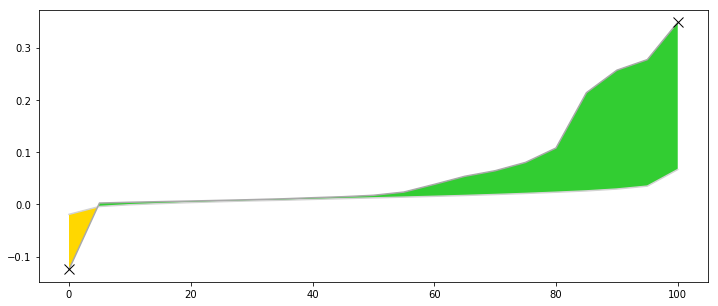

In [122]:
kpimap.compare(random_kpimap_sr, sma1_kpimap_sr)

## L4
## scoremap

Take into account multiple weighted indicators and generate a score from 1 to 100

In [33]:
from vectorbt.optimizer.gridsearch import scoremap

<module 'vectorbt.optimizer.gridsearch.scoremap' from '/Users/olegpolakow/Documents/SourceTree/vector-bt/vectorbt/optimizer/gridsearch/scoremap.py'>

In [37]:
sma_scoremap_sr = scoremap.from_kpimaps([sma1_kpimap_sr, sma2_kpimap_sr], [2/3, 1/3], [False, False])

1-100-scoremap
min (1, 1): 1.0
max (76, 100): 99.3970866528
passed. 0.01s


## L5 
## matrix

Reshape 2d-parameter grid into a matrix and display as a heatmap

In [35]:
from vectorbt.optimizer.gridsearch import matrix

<module 'vectorbt.optimizer.gridsearch.matrix' from '/Users/olegpolakow/Documents/SourceTree/vector-bt/vectorbt/optimizer/gridsearch/matrix.py'>

In [38]:
sma_matrix_df = matrix.from_map(sma1_kpimap_sr, symmetric=True).fillna(0)

100-100-matrix
passed. 1.53s


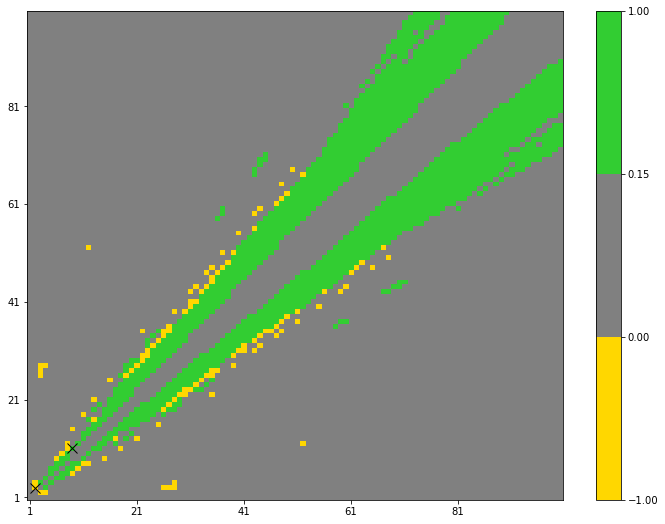

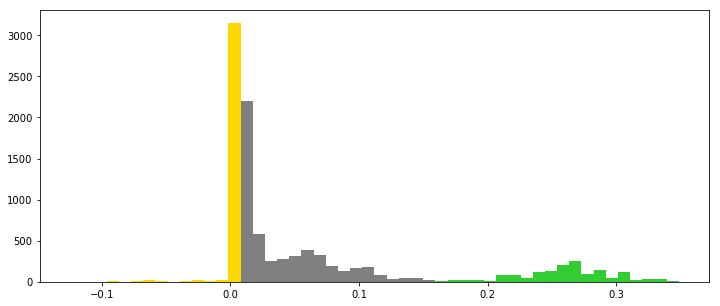

In [118]:
cmap, norm = graphics.discrete_cmap([-1, 0, 0.15, 1], ['gold', 'grey', 'limegreen'])
matplotlib.rcParams['figure.figsize'] = (12, 9)
matrix.plot(sma_matrix_df, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)
graphics.plot_hist(sma_matrix_df, cmap, norm)

Compare KPI distribution to that of random map

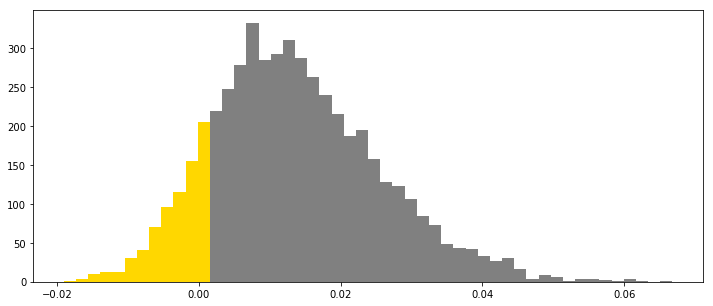

In [119]:
graphics.plot_hist(random_kpimap_sr, cmap, norm)